Install the packages.
```
!pip install torch torchvision transformers textwrap numpy pandas tqdm opencv-python
```

To mount Google Drive in Google Colab, please execute the code below.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Hide warnings.

In [2]:
import warnings
warnings.filterwarnings('ignore')

Set the SEED to ensure reproducability.

In [3]:
def set_seed(seed: int = 42):
    import random, torch, os
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False

set_seed(42)

Define the directory.

In [4]:
import os

# create a working folder
root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'woa7015-med-vqa')
data_dir = os.path.join(root_dir, 'data', 'Slake1.0')
img_dir = os.path.join(data_dir, 'imgs')
working_dir = os.path.join(root_dir, 'baseline-vggtransformer')
save_dir = os.path.join(working_dir, 'weights_v3')

if not os.path.exists(working_dir):
    os.makedirs(working_dir)

if os.getcwd() != working_dir:
    os.chdir(working_dir)

assert os.getcwd() == working_dir
print(f"Root directory: {root_dir}")
print(f"Data directory: {data_dir}")
print(f"Image directory: {img_dir}")
print(f"Working directory: {working_dir}")
print(f"Current directory: {os.getcwd()}")

Root directory: /content/drive/MyDrive/woa7015-med-vqa
Data directory: /content/drive/MyDrive/woa7015-med-vqa/data/Slake1.0
Image directory: /content/drive/MyDrive/woa7015-med-vqa/data/Slake1.0/imgs
Working directory: /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer
Current directory: /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer


Load the `SLAKE`

In [5]:
import pandas as pd

train_df = pd.read_json(os.path.join(data_dir, 'train.json'))
validate_df = pd.read_json(os.path.join(data_dir, 'validate.json'))
test_df = pd.read_json(os.path.join(data_dir, 'test.json'))

print("train:", train_df.shape)
print("validate:", validate_df.shape)
print("test:", test_df.shape)

train: (9835, 12)
validate: (2099, 12)
test: (2094, 12)


Filter the records that have Chinese questions.

In [6]:
train_df = train_df[train_df['q_lang'] == 'en'].reset_index(drop=True)
validate_df = validate_df[validate_df['q_lang'] == 'en'].reset_index(drop=True)
test_df = test_df[test_df['q_lang'] == 'en'].reset_index(drop=True)

print("train:", train_df.shape)
print("validate:", validate_df.shape)
print("test:", test_df.shape)

train: (4919, 12)
validate: (1053, 12)
test: (1061, 12)


A glance of the dataset.

In [7]:
sample_df = train_df.sample(5)
sample_df

,img_id,img_name,question,answer,q_lang,location,modality,answer_type,base_type,content_type,triple,qid
373,16,xmlab16/source.jpg,What modality is used to take this image?,MRI,en,Abdomen,MRI,OPEN,vqa,Modality,"[vhead, _, _]",373
4915,99,xmlab99/source.jpg,Does the picture contain liver?,Yes,en,Lung,CT,CLOSED,vqa,Organ,"[vhead, _, _]",4915
4344,593,xmlab593/source.jpg,Are there organs in the picture that can absor...,No,en,Chest_lung,CT,CLOSED,kvqa,KG,"[vhead, can, absorb nutrients]",4344
3554,485,xmlab485/source.jpg,Where does the picture show?,Head,en,Brain_Tissue,MRI,OPEN,vqa,Position,"[vhead, _, _]",3554
3298,441,xmlab441/source.jpg,Where is the brain tumor?,Upper Left Lobe,en,Brain_Tissue,MRI,OPEN,vqa,Position,"[vhead, _, _]",3298


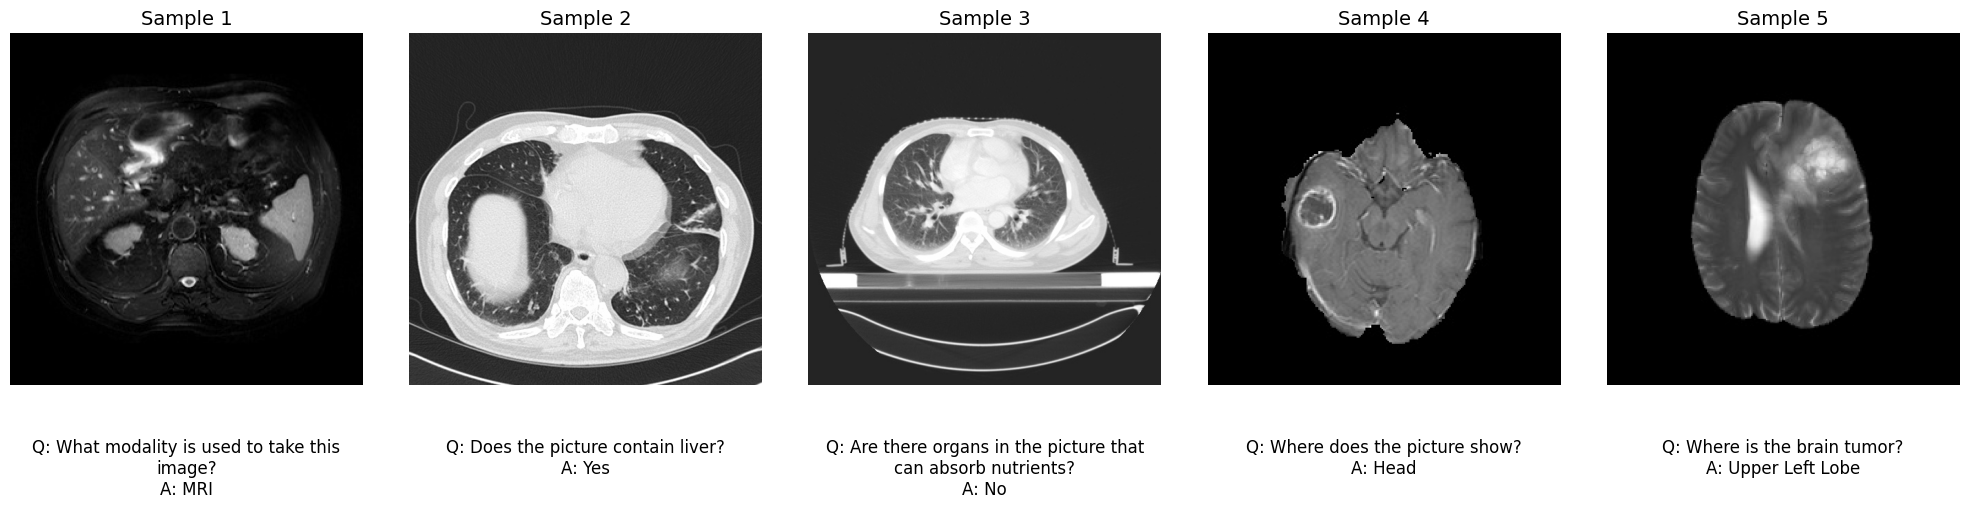

In [8]:
from utils import show_samples

show_samples(sample_df, img_dir=os.path.join(data_dir, 'imgs'))

Build Vocabulary for Answer

In [9]:
from collections import Counter

def build_answer_vocab(df,  min_freq=1):
    counter = Counter(sorted(df["answer"].dropna().unique()))

    ans_to_idx = {'unknown': 0}
    idx_to_ans = {0: 'unknown'}

    idx = 1
    for ans, freq in counter.items():
        if freq >= min_freq:
            ans_to_idx[ans] = idx
            idx_to_ans[idx] = ans
            idx += 1

    return ans_to_idx, idx_to_ans

Build SLAKEDataset

In [10]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import torch, json, os

class SLAKEDataset(Dataset):
    def __init__(self, df, img_dir, tokenizer, ans_to_idx, image_size=224, max_question_len=24):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.img_dir = img_dir
        self.ans_to_idx = ans_to_idx
        self.max_question_len = max_question_len
        self.pad_token = tokenizer.pad_token_id
        self.image_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # load image
        img_path = os.path.join(self.img_dir, row["img_name"])
        image = Image.open(img_path).convert("RGB")
        image = self.image_transform(image)

        # tokenize question
        question = row['question']
        tokens = self.tokenizer.encode(
            question,
            max_length=self.max_question_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).squeeze(0)
        question_mask = (tokens == self.pad_token)

        # Get answer index
        answer = row['answer']
        answer_idx = self.ans_to_idx.get(answer, 0)  # 0 for unknown

        return {
            "qid": torch.tensor(row["qid"], dtype=torch.long),
            "image": image,
            "question": tokens,
            "question_mask": question_mask,
            "answer": torch.tensor(answer_idx, dtype=torch.long)
        }

Get the longest length of the sentence.

In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_source_length = 0
max_target_length = 0

for _, row in train_df.iterrows():
    source_ids = tokenizer.encode(
        row["question"],
        add_special_tokens=True
    )
    target_ids = tokenizer.encode(
        row["answer"],
        add_special_tokens=True
    )

    max_source_length = max(max_source_length, len(source_ids))
    max_target_length = max(max_target_length, len(target_ids))

max_seq_length = max(max_source_length, max_target_length)
print(f"Max (question) length: {max_source_length}")
print(f"Max (answer) length: {max_target_length}")
print(f"Max overall sequence length: {max_seq_length}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Max (question) length: 24
Max (answer) length: 35
Max overall sequence length: 35


Get the first image.

In [12]:
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ans_to_idx, idx_to_ans = build_answer_vocab(train_df)

train_dataset = SLAKEDataset(df=train_df, img_dir=img_dir, tokenizer=tokenizer, ans_to_idx=ans_to_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
input, output = None, None

for batch in train_loader:
    images = batch['image'].to(device)
    questions = batch['question'].to(device)
    question_mask = batch['question_mask'].to(device)
    answers = batch["answer"].to(device)

    print("image:", images.shape)
    print("question:", questions.shape, "question_mask:", question_mask.shape)
    print("answer:", answers.shape)
    break

print("ans_to_idx:", len(ans_to_idx))

image: torch.Size([32, 3, 224, 224])
question: torch.Size([32, 24]) question_mask: torch.Size([32, 24])
answer: torch.Size([32])
ans_to_idx: 229


Sanity test for vocabulary.

In [13]:
batch = next(iter(train_loader))
qid = batch["qid"]
labels = batch["answer"]

for id, label in zip(qid, labels):
    qid_val = id.item()
    label_val = label.item()

    print("qid:", qid_val)
    print("label idx:", label_val)
    print("decoded answer:", idx_to_ans.get(label_val))

    print("ground truth answer:",train_df.loc[train_df["qid"] == qid_val, "answer"].values)
    print("-" * 40)

qid: 2372
label idx: 228
decoded answer: Yes
ground truth answer: ['Yes']
----------------------------------------
qid: 1674
label idx: 41
decoded answer: CT
ground truth answer: ['CT']
----------------------------------------
qid: 1006
label idx: 228
decoded answer: Yes
ground truth answer: ['Yes']
----------------------------------------
qid: 3150
label idx: 94
decoded answer: Larynx
ground truth answer: ['Larynx']
----------------------------------------
qid: 511
label idx: 146
decoded answer: Nodule
ground truth answer: ['Nodule']
----------------------------------------
qid: 2316
label idx: 38
decoded answer: Breathe
ground truth answer: ['Breathe']
----------------------------------------
qid: 849
label idx: 228
decoded answer: Yes
ground truth answer: ['Yes']
----------------------------------------
qid: 358
label idx: 49
decoded answer: Chest
ground truth answer: ['Chest']
----------------------------------------
qid: 3402
label idx: 78
decoded answer: Head
ground truth answer:

Build ImageEmbedding

In [14]:
import torch, math
import torch.nn as nn
from torchvision import models

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2D, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("d_model must be divisible by 4 for 2D encoding")

        self.d_model = d_model
        # Create the 2D encodings
        pe = torch.zeros(d_model, height, width)

        # Split d_model into two (one for row, one for col)
        d_half = d_model // 2
        div_term = torch.exp(torch.arange(0, d_half, 2).float() * (-math.log(10000.0) / d_half))

        # Row positions (y)
        pos_w = torch.arange(0, width).unsqueeze(1)
        # Column positions (x)
        pos_h = torch.arange(0, height).unsqueeze(1)

        # Fill Row encodings
        pe[0:d_half:2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[1:d_half:2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

        # Fill Column encodings
        pe[d_half::2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_half+1::2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)

        self.register_buffer('pe', pe.unsqueeze(0)) # Shape: (1, d_model, H, W)

    def forward(self, x):
        # x shape: (batch, d_model, H, W)
        return x + self.pe


class ImageEmbedding(torch.nn.Module):
    def __init__(self, d_model, pretrained=True, dropout=0.1):
        super().__init__()
        resnet = resnet = models.resnet50(pretrained=pretrained)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.projection = nn.Conv2d(2048, d_model, kernel_size=1)
        self.pos_encoder = PositionalEncoding2D(d_model, 7, 7)
        self.img_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):                       # x: (b, 3, 224, 224)
        features = self.features(x)             # (b, 2048, 7, 7)
        features = self.projection(features)    # (b, d_model, 7, 7)
        features = self.pos_encoder(features)   # (b, d_model, 7, 7)
        features = self.dropout(features)
        features = features.flatten(2)          # (b, d_model, 49)
        features = features.permute(0, 2, 1)    # (b, 49, d_model)
        return features

Check the output shape.

In [15]:
img_embedding = ImageEmbedding(d_model=512, pretrained=True).to(device)

with torch.no_grad():
    output = img_embedding(images)

print("input:", images.shape)
print("output:", output.shape)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


input: torch.Size([32, 3, 224, 224])
output: torch.Size([32, 49, 512])


Build VQA Model - ResNet-Transformer

In [16]:
import torch.nn.functional as F

class AttentionPooling(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # A simple layer to calculate importance scores
        self.attn_weights = nn.Linear(d_model, 1)

    def forward(self, x, mask=None):
                                                            # (b, seq_len, d_model)
        scores = self.attn_weights(x).squeeze(-1)           # (b, seq_len)

        if mask is not None:
            scores = scores.masked_fill(mask, -1e9)

        weights = F.softmax(scores, dim=-1).unsqueeze(-1)   # (b, seq_len, 1)
        pooled = torch.sum(x * weights, dim=1)              # (b, d_model)
        return pooled


class VQAModel(torch.nn.Module):
    def __init__(
        self, d_model, vocab_size, answer_size, nhead, num_encoder_layers, num_decoder_layers, d_ff, dropout
    ):
        super().__init__()
        self.img_embedding = ImageEmbedding(d_model=d_model, pretrained=True)
        self.question_embedding = nn.Embedding(vocab_size, d_model)
        self.question_pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_ff, dropout=dropout, batch_first=True)
        self.text_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.cross_attention = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(d_model)
        self.attn_pool = AttentionPooling(d_model)
        self.dropout = nn.Dropout(p=0.5)
        self.classifier = nn.Linear(d_model, answer_size)

    def encode(self, images, questions):
        features = self.img_embedding(images)
        questions = self.question_embedding(questions)
        questions = self.question_pos_encoder(questions)
        return features, questions

    def forward(self, images, questions, question_mask):
        features, questions = self.encode(images, questions)
        questions = self.text_encoder(questions, src_key_padding_mask=question_mask)
        attention, weights = self.cross_attention(query=questions, key=features, value=features)
        fused = self.norm(attention + questions)
        pooled = self.attn_pool(fused, mask=question_mask)
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return logits

Check the output shape.

In [17]:
model = VQAModel(
    d_model=512, vocab_size=tokenizer.vocab_size, answer_size=len(ans_to_idx),
    nhead=2, num_encoder_layers=2, num_decoder_layers=2, d_ff=2048, dropout=0.3
).to(device)

with torch.no_grad():
    logits = model(images, questions, question_mask)

print("images:", images.shape)
print("questions:", questions.shape)
print("output:", logits.shape)

images: torch.Size([32, 3, 224, 224])
questions: torch.Size([32, 24])
output: torch.Size([32, 229])


Sanity test before training. This ensure that our setup is correct if the model is able to learn one batch repeatedly and reaches accuracy of 100%.

In [18]:
batch = next(iter(train_loader))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for step in range(200):
    optimizer.zero_grad()
    images = batch["image"].to(device)
    questions = batch["question"].to(device)
    question_mask = batch["question_mask"].to(device)
    labels = batch["answer"].to(device)

    logits = model(images, questions, question_mask)
    loss = criterion(logits, labels)

    before = model.classifier.weight.clone()
    loss.backward()
    optimizer.step()
    after = model.classifier.weight
    acc = (logits.argmax(1) == labels).float().mean()

    print("change:", (before - after).abs().sum())
    print(step, loss.item(), acc.item())

    if acc.item() == 1.0:
        break

change: tensor(11.7244, device='cuda:0', grad_fn=<SumBackward0>)
0 5.652443885803223 0.03125
change: tensor(10.3607, device='cuda:0', grad_fn=<SumBackward0>)
1 5.184950351715088 0.0
change: tensor(9.7783, device='cuda:0', grad_fn=<SumBackward0>)
2 4.613689422607422 0.25
change: tensor(9.3983, device='cuda:0', grad_fn=<SumBackward0>)
3 4.170665264129639 0.25
change: tensor(9.1412, device='cuda:0', grad_fn=<SumBackward0>)
4 3.8160974979400635 0.25
change: tensor(8.9057, device='cuda:0', grad_fn=<SumBackward0>)
5 3.403111457824707 0.28125
change: tensor(8.7326, device='cuda:0', grad_fn=<SumBackward0>)
6 3.2596840858459473 0.25
change: tensor(8.5344, device='cuda:0', grad_fn=<SumBackward0>)
7 2.9166064262390137 0.25
change: tensor(8.3434, device='cuda:0', grad_fn=<SumBackward0>)
8 2.6264474391937256 0.40625
change: tensor(8.1784, device='cuda:0', grad_fn=<SumBackward0>)
9 2.284083366394043 0.4375
change: tensor(8.0299, device='cuda:0', grad_fn=<SumBackward0>)
10 1.935014247894287 0.5625
ch

Build EarlyStopping

In [23]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, save_dir=''):
        self.patience = patience
        self.min_delta = min_delta
        self.save_dir = save_dir
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model, val_loss, epoch)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model, val_loss, epoch)
            self.counter = 0

    def save_checkpoint(self, model, val_loss, epoch):
        file_name = f"vqa_epoch{epoch+1}_loss{val_loss:.4f}.pth"
        save_path = os.path.join(self.save_dir, file_name)

        torch.save(model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

Train the VQA model

In [24]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn

batch_size = 64
num_epochs = 35
learning_rate = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ans_to_idx, idx_to_ans = build_answer_vocab(train_df)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = SLAKEDataset(df=train_df, img_dir=img_dir, tokenizer=tokenizer, ans_to_idx=ans_to_idx)
val_dataset = SLAKEDataset(df=validate_df, img_dir=img_dir, tokenizer=tokenizer, ans_to_idx=ans_to_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model = VQAModel(
    d_model=512, vocab_size=tokenizer.vocab_size, answer_size=len(ans_to_idx), nhead=2,
    num_encoder_layers=2, num_decoder_layers=2, d_ff=2048, dropout=0.5
).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs//2, eta_min=1e-6)
early_stopper = EarlyStopping(patience=5, save_dir=save_dir)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

def compute_accuracy(logits, labels):
    preds = logits.argmax(dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct, total

for epoch in range(num_epochs):
    # ------------ training phrase ------------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    batch_iterator = tqdm(train_loader, leave=True, desc=f'Processing epoch {epoch+1:02d}')

    for batch in batch_iterator:
        images = batch["image"].to(device)
        questions = batch["question"].to(device)
        question_mask = batch["question_mask"].to(device)
        labels = batch["answer"].to(device)

        optimizer.zero_grad()

        # forward pass
        logits = model(images, questions, question_mask)
        loss = criterion(logits, labels)

        # backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # update statistics
        train_loss += loss.item()
        correct, total = compute_accuracy(logits, labels)
        batch_acc = correct / total
        train_correct += correct
        train_total += total

        # update progress bar
        batch_iterator.set_postfix(loss=f"{loss.item():.4f}", acc=f"{batch_acc*100:.2f}", lr=f"{optimizer.param_groups[0]['lr']:.2e}")

    # calculate average training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * train_correct / train_total

    # ------------ validation phrase ------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            questions = batch["question"].to(device)
            question_mask = batch["question_mask"].to(device)
            labels = batch["answer"].to(device)

            # forward pass
            logits = model(images, questions, question_mask)
            loss = criterion(logits, labels)

            # update statistics
            val_loss += loss.item()
            correct, total = compute_accuracy(logits, labels)
            val_correct += correct
            val_total += total

    # calculate average validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * val_correct / val_total

    # update learning rate scheduler
    scheduler.step(avg_val_loss)

    # store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # print epoch results
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # check early stopping
    early_stopper(avg_val_loss, model, epoch)
    if early_stopper.early_stop:
            print("Early stopping triggered. Training finished.")
            break

    print('-' * 60)

Processing epoch 01: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s, acc=16.36, loss=3.5346, lr=1.00e-04]



Epoch [1/35]
Train Loss: 3.9602, Train Acc: 18.85%
Val Loss: 3.2304, Val Acc: 31.53%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch1_loss3.2304.pth
------------------------------------------------------------


Processing epoch 02: 100%|██████████| 77/77 [01:00<00:00,  1.26it/s, acc=45.45, loss=2.7923, lr=9.14e-05]



Epoch [2/35]
Train Loss: 3.0247, Train Acc: 36.55%
Val Loss: 2.6460, Val Acc: 46.06%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch2_loss2.6460.pth
------------------------------------------------------------


Processing epoch 03: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s, acc=40.00, loss=2.7850, lr=9.42e-05]



Epoch [3/35]
Train Loss: 2.5488, Train Acc: 48.51%
Val Loss: 2.3453, Val Acc: 50.52%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch3_loss2.3453.pth
------------------------------------------------------------


Processing epoch 04: 100%|██████████| 77/77 [00:59<00:00,  1.30it/s, acc=52.73, loss=2.4157, lr=9.54e-05]



Epoch [4/35]
Train Loss: 2.2735, Train Acc: 54.67%
Val Loss: 2.1685, Val Acc: 55.94%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch4_loss2.1685.pth
------------------------------------------------------------


Processing epoch 05: 100%|██████████| 77/77 [01:04<00:00,  1.19it/s, acc=56.36, loss=2.3222, lr=9.61e-05]



Epoch [5/35]
Train Loss: 2.0971, Train Acc: 58.02%
Val Loss: 1.9989, Val Acc: 60.59%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch5_loss1.9989.pth
------------------------------------------------------------


Processing epoch 06: 100%|██████████| 77/77 [00:59<00:00,  1.30it/s, acc=65.45, loss=1.9374, lr=9.67e-05]



Epoch [6/35]
Train Loss: 1.9728, Train Acc: 61.58%
Val Loss: 1.9556, Val Acc: 62.11%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch6_loss1.9556.pth
------------------------------------------------------------


Processing epoch 07: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s, acc=61.82, loss=2.0188, lr=9.68e-05]



Epoch [7/35]
Train Loss: 1.8755, Train Acc: 63.96%
Val Loss: 1.9236, Val Acc: 63.63%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch7_loss1.9236.pth
------------------------------------------------------------


Processing epoch 08: 100%|██████████| 77/77 [00:59<00:00,  1.28it/s, acc=56.36, loss=1.9498, lr=9.69e-05]



Epoch [8/35]
Train Loss: 1.8107, Train Acc: 66.31%
Val Loss: 1.8462, Val Acc: 65.05%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch8_loss1.8462.pth
------------------------------------------------------------


Processing epoch 09: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s, acc=69.09, loss=1.8566, lr=9.71e-05]



Epoch [9/35]
Train Loss: 1.7300, Train Acc: 68.47%
Val Loss: 1.8293, Val Acc: 64.96%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch9_loss1.8293.pth
------------------------------------------------------------


Processing epoch 10: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s, acc=70.91, loss=1.6754, lr=9.72e-05]



Epoch [10/35]
Train Loss: 1.6810, Train Acc: 69.67%
Val Loss: 1.8000, Val Acc: 66.57%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch10_loss1.8000.pth
------------------------------------------------------------


Processing epoch 11: 100%|██████████| 77/77 [01:01<00:00,  1.25it/s, acc=80.00, loss=1.4029, lr=9.73e-05]



Epoch [11/35]
Train Loss: 1.6417, Train Acc: 71.56%
Val Loss: 1.8525, Val Acc: 66.10%
EarlyStopping counter: 1 out of 5
------------------------------------------------------------


Processing epoch 12: 100%|██████████| 77/77 [00:59<00:00,  1.29it/s, acc=78.18, loss=1.4372, lr=9.71e-05]



Epoch [12/35]
Train Loss: 1.5936, Train Acc: 72.54%
Val Loss: 1.7950, Val Acc: 68.09%
Model saved to /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch12_loss1.7950.pth
------------------------------------------------------------


Processing epoch 13: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s, acc=76.36, loss=1.5539, lr=9.73e-05]



Epoch [13/35]
Train Loss: 1.5368, Train Acc: 75.46%
Val Loss: 1.7998, Val Acc: 68.85%
EarlyStopping counter: 1 out of 5
------------------------------------------------------------


Processing epoch 14: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s, acc=69.09, loss=1.6451, lr=9.73e-05]



Epoch [14/35]
Train Loss: 1.5181, Train Acc: 75.44%
Val Loss: 1.8607, Val Acc: 67.52%
EarlyStopping counter: 2 out of 5
------------------------------------------------------------


Processing epoch 15: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s, acc=83.64, loss=1.3632, lr=9.71e-05]



Epoch [15/35]
Train Loss: 1.4807, Train Acc: 76.89%
Val Loss: 1.8660, Val Acc: 67.62%
EarlyStopping counter: 3 out of 5
------------------------------------------------------------


Processing epoch 16: 100%|██████████| 77/77 [01:00<00:00,  1.27it/s, acc=83.64, loss=1.3777, lr=9.71e-05]



Epoch [16/35]
Train Loss: 1.4394, Train Acc: 78.63%
Val Loss: 1.8442, Val Acc: 68.85%
EarlyStopping counter: 4 out of 5
------------------------------------------------------------


Processing epoch 17: 100%|██████████| 77/77 [01:00<00:00,  1.28it/s, acc=80.00, loss=1.3933, lr=9.72e-05]



Epoch [17/35]
Train Loss: 1.4033, Train Acc: 79.77%
Val Loss: 1.8102, Val Acc: 69.71%
EarlyStopping counter: 5 out of 5
Early stopping triggered. Training finished.


Check out the best epoch.

In [28]:
import numpy as np
import os, glob

pth_files = glob.glob(os.path.join(save_dir, "*.pth"))
if not pth_files:
    raise FileNotFoundError("No .pth files found in save_dir")
best_weight_path = pth_files[-1]
print("best_weight_path:", best_weight_path)

best_weight_path: /content/drive/MyDrive/woa7015-med-vqa/baseline-vggtransformer/weights_v4/vqa_best_epoch12_loss1.7950.pth


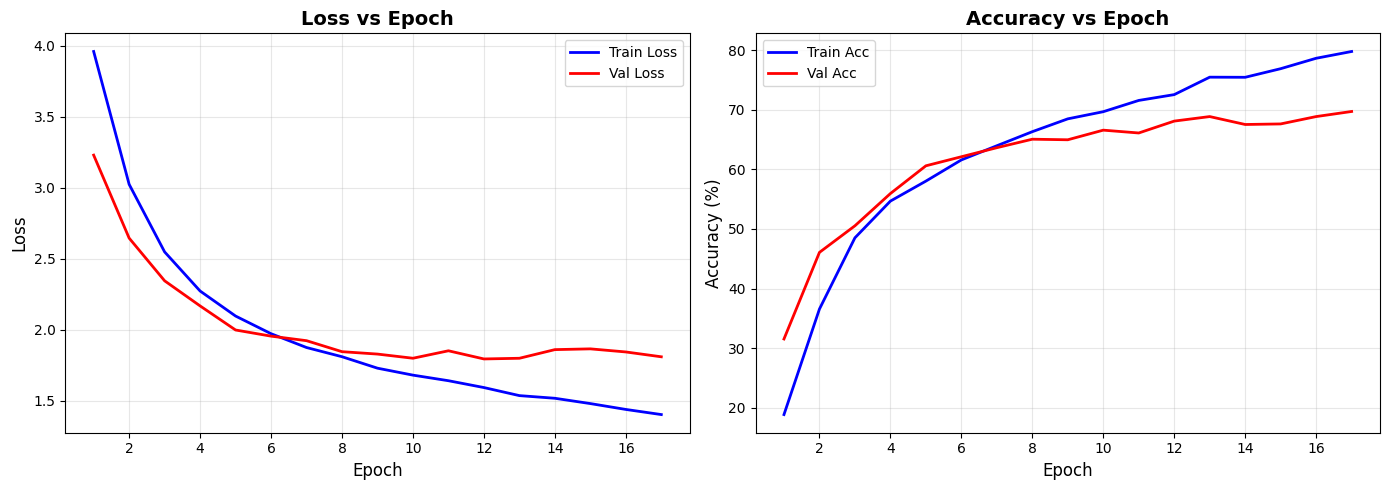

In [34]:
from utils import plot_graph

plot_graph(train_losses, val_losses, train_accs, val_accs, num_epochs=17)

Test the model.

In [30]:
# Create test dataset
test_dataset = SLAKEDataset(df=test_df,img_dir=img_dir,tokenizer=tokenizer, ans_to_idx=ans_to_idx)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

model.load_state_dict(torch.load(best_weight_path))
model.to(device)
model.eval()
results = []
test_correct, test_total = 0, 0
test_loss = 0.0

with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_loader, desc='Testing')):
        images = batch["image"].to(device)
        questions = batch["question"].to(device)
        question_mask = batch["question_mask"].to(device)
        answers = batch["answer"].to(device)

        # forward pass
        logits = model(images, questions, question_mask)
        loss = criterion(logits, answers)

        # Accumulate loss
        test_loss += loss.item()
        _, predicted = logits.max(1)

        # Get the actual answer indices
        true_answer_idx = answers.item()
        pred_answer_idx = predicted.item()

        # Convert indices to answer text
        true_answer = idx_to_ans[true_answer_idx]
        pred_answer = idx_to_ans[pred_answer_idx]

        # Decode question (remove padding and special tokens)
        question_ids = questions[0].cpu().numpy()
        question_text = tokenizer.decode(question_ids, skip_special_tokens=True)

        # Get image path from dataset
        img_name = test_dataset.df.iloc[idx]['img_name']

        # Store result
        is_correct = (true_answer_idx == pred_answer_idx)
        results.append({
            "qid": batch["qid"].item(),
            'img_name': img_name,
            'question': question_text,
            'true_answer': true_answer,
            'predicted_answer': pred_answer,
            'correct': is_correct,
            'confidence': torch.softmax(logits, dim=1)[0][pred_answer_idx].item()
        })

        test_correct += is_correct
        test_total += 1

# Calculate overall accuracy
test_accuracy = 100. * test_correct / test_total
avg_test_loss = test_loss / len(test_loader)
print(f'\nTest Accuracy: {test_accuracy:.2f}% ({test_correct}/{test_total})')
print(f"Test Loss: {avg_test_loss}")

Testing: 100%|██████████| 1061/1061 [02:27<00:00,  7.20it/s]


Test Accuracy: 66.26% (703/1061)
Test Loss: 1.7999019936274854


Analyze the performance (Open and Close-ended)

In [31]:
result_df = pd.DataFrame(results)
result_df = result_df[['qid', 'true_answer', 'predicted_answer', 'correct']]
merged_df = test_df.merge(result_df, on="qid", how="left")
merged_df = merged_df[["qid", "img_name", "question", "answer_type", "answer", "predicted_answer", "correct"]]
merged_df.head(5)

,qid,img_name,question,answer_type,answer,predicted_answer,correct
0,11934,xmlab102/source.jpg,What modality is used to take this image?,OPEN,CT,CT,True
1,11935,xmlab102/source.jpg,Which part of the body does this image belong to?,OPEN,Chest,Abdomen,False
2,11936,xmlab102/source.jpg,What is the main organ in the image?,OPEN,"Lung, Spinal Cord",Lung,False
3,11937,xmlab102/source.jpg,What is the largest organ in the picture?,OPEN,Lung,Lung,True
4,11938,xmlab102/source.jpg,Does the picture contain liver?,CLOSED,No,No,True


In [32]:
accuracy_by_type = (
    merged_df
    .groupby("answer_type")
    .agg(total=("correct", "count"), correct=("correct", "sum"))
)

accuracy_by_type["accuracy"] = accuracy_by_type["correct"] / accuracy_by_type["total"]
accuracy_by_type

,total,correct,accuracy
answer_type,,,
CLOSED,416,260,0.625000
OPEN,645,443,0.686822


Visualize the result from test dataset.

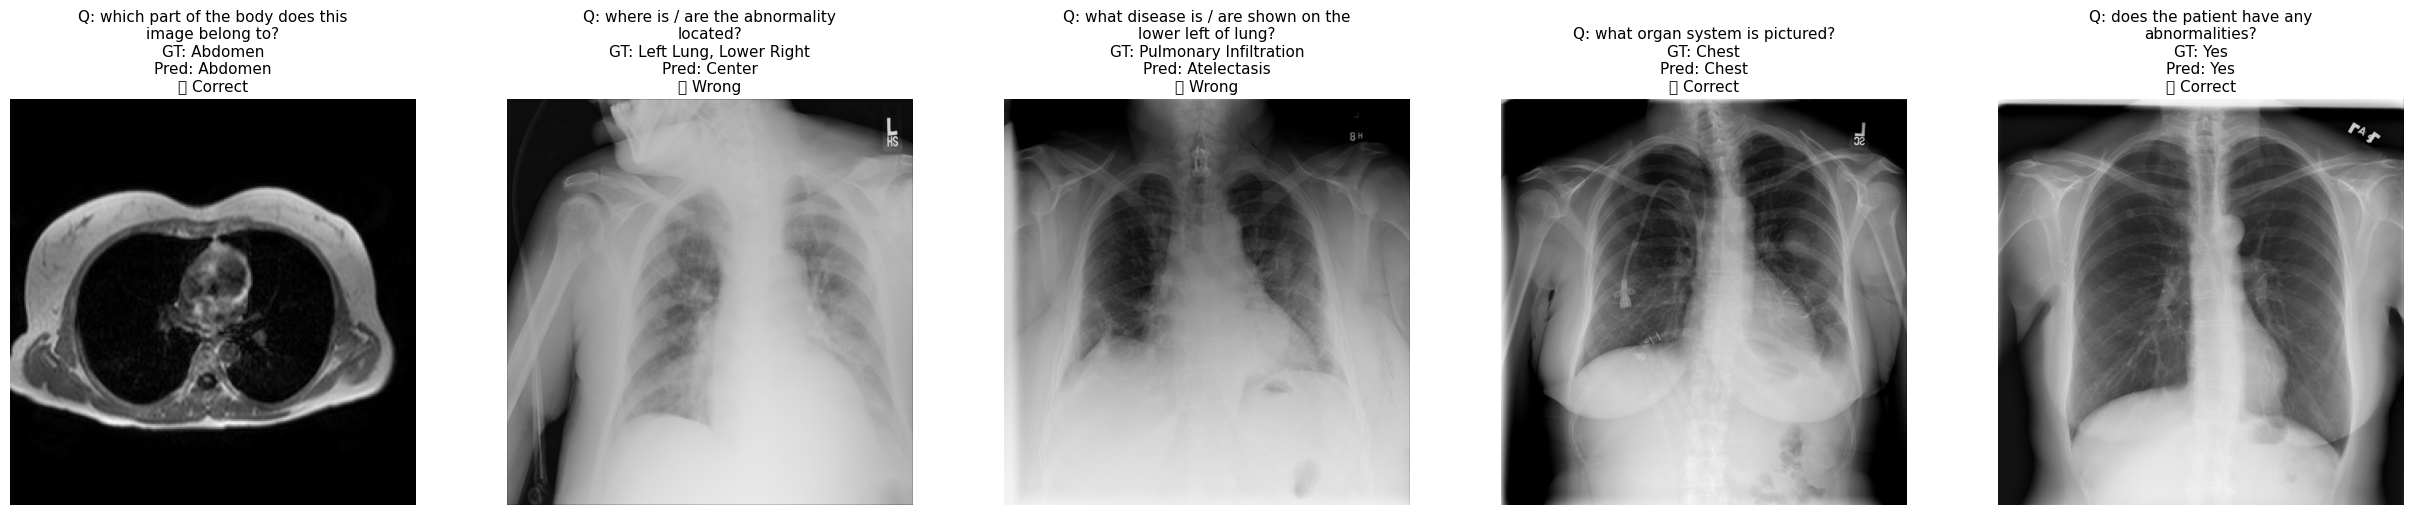

In [33]:
import random, math, textwrap
import matplotlib.pyplot as plt


def visualize_samples(
    results, img_dir, num_samples=5, shuffle=True, figsize=(25, 5)
):
    if shuffle:
        samples = random.sample(results, min(num_samples, len(results)))
    else:
        samples = results[:num_samples]

    n_rows = 1
    n_cols = math.ceil(len(samples) / n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for ax, sample in zip(axes, samples):
        image_path = os.path.join(img_dir, sample["img_name"])
        img = Image.open(image_path).convert("RGB")
        ax.imshow(img)
        ax.axis("off")

        question = textwrap.fill(f"Q: {sample['question']}", width=40)
        gt = textwrap.fill(f"GT: {sample['true_answer']}", width=40)
        pred = textwrap.fill(f"Pred: {sample['predicted_answer']}", width=40)
        status = "✅ Correct" if sample["correct"] else "❌ Wrong"

        title = f"{question}\n{gt}\n{pred}\n{status}"
        ax.set_title(title, fontsize=11, loc="center")

    for ax in axes[len(samples):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_samples(results, img_dir, num_samples=5)